In [533]:
import networkx as nx
import geopandas as gp
import pandas as pd 
import numpy as np
from glob import glob
from shapely.geometry import Point
import matplotlib.pyplot as plt
import cartoframes
import json
import folium
from sklearn.cluster import spectral_clustering
%matplotlib inline

# Download and parse data for networkx

In [3]:
! curl -O https://s3.amazonaws.com/tripdata/201307-201402-citibike-tripdata.zip
! unzip 201307-201402-citibike-tripdata.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  170M  100  170M    0     0   9.9M      0  0:00:17  0:00:17 --:--:-- 12.7M
Archive:  201307-201402-citibike-tripdata.zip
replace 2014-02 - Citi Bike trip data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [7]:
data= pd.concat([pd.read_csv(f) for f in glob("*.csv")])

od =(data.groupby(['start station id', 'end station id'])
         .count()
         .rename(columns={'tripduration' : 'weight'})
         .assign(inv_weight= lambda x: 1.0/x['weight'] )
         .reset_index()[['start station id', 'end station id','weight','inv_weight']])

network = nx.from_pandas_dataframe(od,
                                   source= 'start station id',
                                   target='end station id',
                                   edge_attr='inv_weight',
                                   create_using=nx.DiGraph())
data.groupby('bikeid').count().sort_values(by='gender',ascending=False).head()

# Isolate most active bike

In [ ]:
busybike = data[data['bikeid']==17279]
busybike.sort_values(by='starttime').head()

# Find jumps (or rebalancing routes) for most active bike

In [ ]:
busybikenext = (busybike.sort_values(by='starttime')
                        .assign(nextstationid = busybike.sort_values(by='starttime')['start station id'].shift(-1).fillna(0).astype('int'))
                )

jumps = busybikenext[~(busybikenext['end station id'] == busybikenext['nextstationid'])]

jump_count =(jumps.groupby(['end station id', 'nextstationid'])
         .count()
         .rename(columns={'tripduration' : 'weight'})
         .assign(inv_weight= lambda x: 1.0/x['weight'] )
         .reset_index()[['end station id',
                         'nextstationid',
                         'weight',
                         'inv_weight']])

jumpnetwork = nx.from_pandas_dataframe(jump_count.query('nextstationid != 0'),
                                       source= 'end station id',
                                       target='nextstationid',
                                       edge_attr='inv_weight',
                                       create_using=nx.DiGraph())

# Find all station node positions

In [441]:
stations = (data[['start station id', 'start station latitude', 'start station longitude','start station name',]]
            .drop_duplicates('start station id')
            .rename(columns={'start station latitude':'latitude', 'start station longitude':'longitude'})
            .set_index('start station id'))
station_positions={}
for c in stations.index:
    station_positions[c]=(stations['longitude'][c],stations['latitude'][c])

# Plotting busybike jump network with networkx

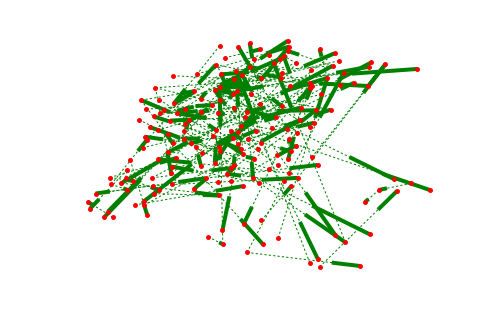

In [445]:
nx.draw(jumpnetwork,pos=station_positions,with_labels=False,node_size=15,style='dotted',edge_color='green',arrows=True)

# Plot rebalancing (jump) network for all bikes

In [446]:
# This cell takes a while to run...
all_jumps = pd.DataFrame()
for i in data['bikeid'].unique():
    bike = data[data['bikeid']==i] 
    nextbike = (bike.sort_values(by='starttime')
                        .assign(nextstationid = bike.sort_values(by='starttime')['start station id'].shift(-1).fillna(0).astype('int'))
                )
    jumps = nextbike[~(nextbike['end station id'] == nextbike['nextstationid'])]
    jumps.head()
    all_jumps = all_jumps.append(jumps)

KeyboardInterrupt: 

In [129]:
all_jump_count =(all_jumps.query('nextstationid != 0').groupby(['end station id', 'nextstationid'])
         .count()
         .rename(columns={'tripduration' : 'weight'})
         .assign(inv_weight= lambda x: 1.0/x['weight'] )
         .reset_index()[['end station id',
                         'nextstationid',
                         'weight',
                         'inv_weight']])

In [133]:
# Find most frequent jump routes
all_jump_count.sort_values(by='weight',ascending=False).head()

,end station id,nextstationid,weight,inv_weight
58143,477,465,2811,0.000356
70985,529,2021,1445,0.000692
68925,521,490,1324,0.000755
69660,524,477,639,0.001565
62019,493,529,639,0.001565


In [ ]:
# Use networkx to analyze total jump network and top-10 jump routes

alljumpnetwork = nx.from_pandas_dataframe(all_jump_count,
                                       source= 'end station id',
                                       target='nextstationid',
                                       edge_attr='inv_weight',
                                       create_using=nx.DiGraph())
topjumpnetwork = nx.from_pandas_dataframe(all_jump_count.sort_values(by='weight',ascending=False).head(10),
                                       source= 'end station id',
                                       target='nextstationid',
                                       edge_attr='inv_weight',
                                       create_using=nx.DiGraph())

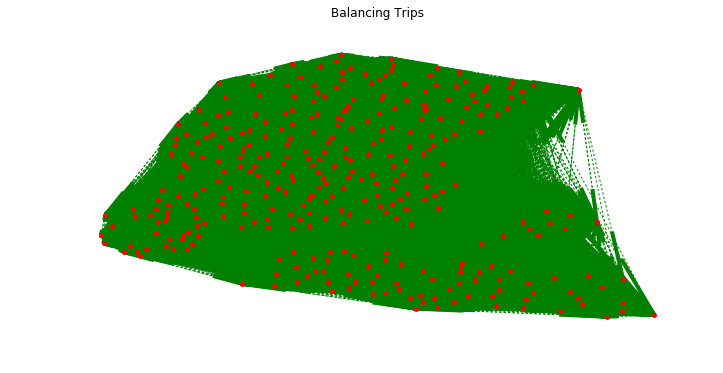

In [146]:
# We're plotting a lot of jump routes here -- may take a minute or two
plt.pyplot.figure(figsize = (12,6))
plt.pyplot.title('All Balancing Trips')
nx.draw(alljumpnetwork,pos=station_positions,with_labels=False,node_size=15,style='dotted',edge_color='green',arrows=True)

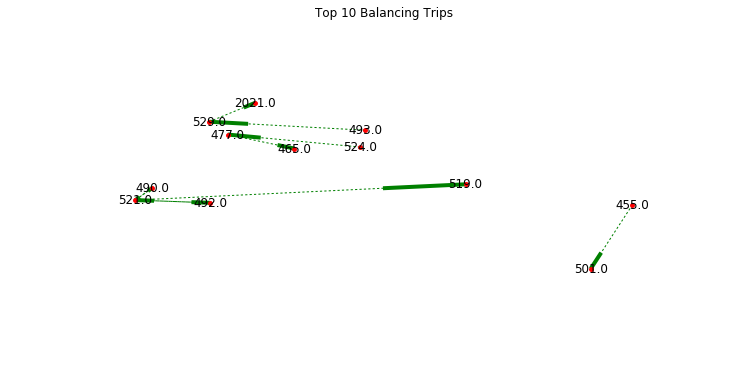

In [149]:
plt.pyplot.title('Top 10 Balancing Trips')
nx.draw(topjumpnetwork,pos=station_positions,with_labels=True,node_size=15,style='dotted',edge_color='green',arrows=True)

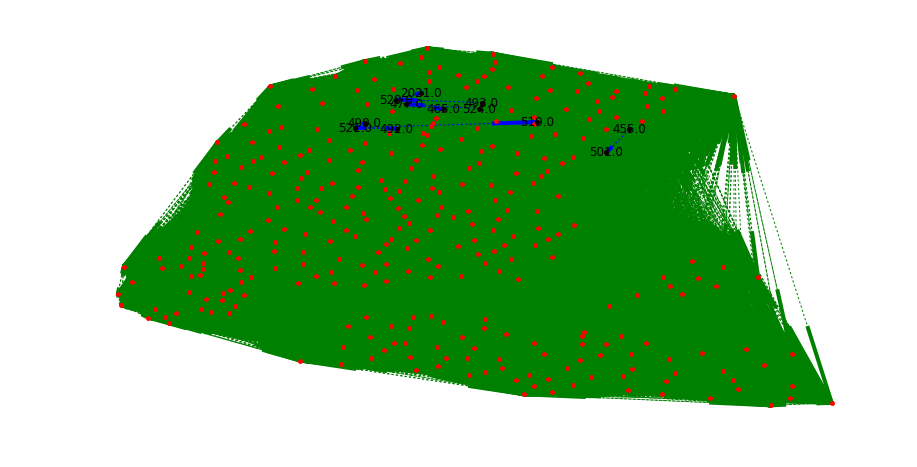

In [151]:
nx.draw(network,pos=station_positions,with_labels=False,node_size=15,style='dotted',edge_color='green',arrows=True)
nx.draw(topjumpnetwork,pos=station_positions,with_labels=True,node_size=15,style='dotted',node_color='black',edge_color='blue',arrows=True)

In [239]:
# visualize with folium
map_bike = folium.Map(location=[40.730020, -73.969053],tiles='cartodbpositron', zoom_start=13)

for i in stations.iterrows():
    folium.CircleMarker(location=[i[1][0],i[1][1]],radius=1,fill_opacity=1).add_to(map_bike)

map_bike

# Centrality Measures

In [414]:
degree_cent = nx.centrality.degree_centrality(network)
between_cent = nx.centrality.betweenness_centrality(network, weight='inv_weight')

In [415]:
closeness_cent = nx.centrality.closeness_centrality(network,distance='inv_weight')

In [158]:
# This is “left” eigenvector centrality which corresponds to the in-edges
eigen_cent = nx.centrality.eigenvector_centrality(network,weight='inv_weight')
eigen_cent_numpy = nx.centrality.eigenvector_centrality_numpy(network,weight='inv_weight')

In [390]:
# This is “right” eigenvector centrality which corresponds to the out-edges
eigen_cent_out = nx.centrality.eigenvector_centrality(network.reverse(),weight='inv_weight')
eigen_cent_numpy_out = nx.centrality.eigenvector_centrality_numpy(network.reverse(),weight='inv_weight')

In [416]:
centralities = {'degree_centrality':degree_cent,
                'betweeness_centrality':between_cent,
                'closeness_centrality':closeness_cent,
                'eigenvector_centrality':eigen_cent,
                'eigenvector_out_centrality':eigen_cent_out}

In [417]:
for key, values in centralities.iteritems():
    stations['{}'.format(key)] = stations['start station id'].map(values)

In [418]:
stations.to_csv('centralities_citibike.csv')

In [485]:
# eight bins diverging and qualitative color palette
diverge_colors = ["#d53e4f",
                    "#f46d43",
                    "#fdae61",
                    "#fee08b",
                    "#e6f598",
                    "#abdda4",
                    "#66c2a5",
                    "#3288bd"]

qualitative_colors=['#7fc97f',
                    '#beaed4',
                    '#fdc086',
                    '#ffff99',
                    '#386cb0',
                    '#f0027f',
                    '#bf5b17',
                    '#666666',]

In [327]:
values = degree_cent.values()
bins = np.linspace(min(degree_cent.values()),max(degree_cent.values()), num=8)
binassign = np.digitize(values, bins)
binassign = binassign - 1

In [368]:
for num, centralities in enumerate([degree_cent,between_cent,closeness_cent,eigen_cent]):
    values = centralities.values()
    bins = np.linspace(min(centralities.values()),max(centralities.values()), num=8)
    binassign = np.digitize(values, bins)
    binassign = binassign - 1
    bin_dict = dict(zip(centralities.keys(), binassign))
    map_bike = folium.Map(location=[40.730020, -73.969053],
                          tiles='cartodbdark_matter',
                          zoom_start=12,
                         )

    for i in stations.iterrows():
        station_id = i[0]
        folium.CircleMarker(location=[i[1][0],i[1][1]],
                            radius=1,fill_opacity=1,
                            color=diverge_colors[bin_dict[station_id]],
                            fill_color=diverge_colors[bin_dict[station_id]]).add_to(map_bike)
    map_bike.save('centralitymap_{}.html'.format(num))

# Graph Partitioning explorations

## Spectral clustering

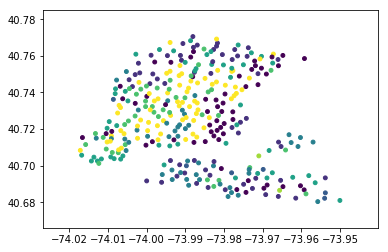

In [500]:
laplacian_matrix = nx.directed_laplacian_matrix(network)
spectral8 = sklearn.cluster.SpectralClustering()
labels = spectral8.fit_predict(laplacian_matrix)
nx.draw_networkx_nodes(network,pos=station_positions,node_color=labels,with_labels=False,node_size=15)

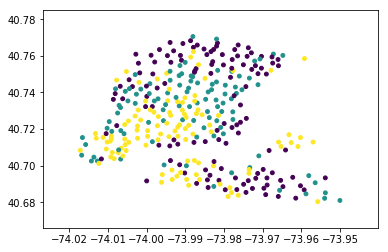

In [501]:
# three clusters
spectral = sklearn.cluster.SpectralClustering(n_clusters=3)
labels = spectral.fit_predict(laplacian_matrix)
nx.draw_networkx_nodes(network,pos=station_positions,node_color=labels,with_labels=False,node_size=15)

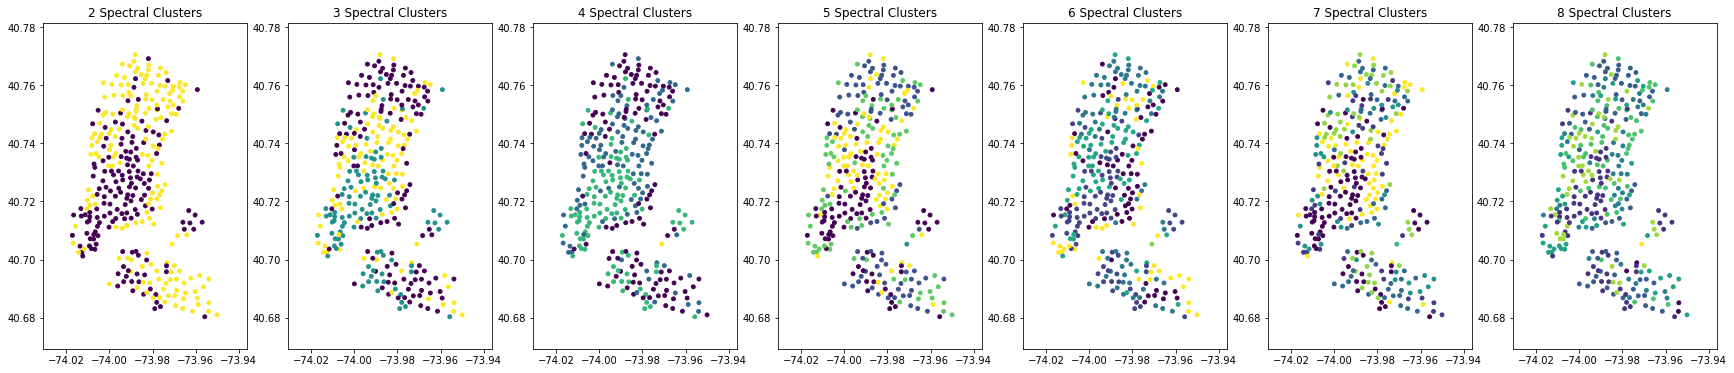

In [568]:
# clusters of sizes 2 to 8
fig, axes = plt.subplots(ncols=7, figsize = (30,6))
for ax, i in zip(axes, range(2,9)):
    spectral = sklearn.cluster.SpectralClustering(n_clusters=i)
    labels = spectral.fit_predict(laplacian_matrix)
    nx.draw_networkx_nodes(network,pos=station_positions,node_color=labels,cmap='viridis',with_labels=False,node_size=15, ax=ax)
    ax.set_title('{} Spectral Clusters'.format(i))

In [502]:
three_spectral_clusters = dict(zip(network.nodes(),labels))

In [525]:
map_bike = folium.Map(location=[40.730020, -73.969053],
                      tiles='cartodbpositron',
                      zoom_start=12,
                     )
for value in stations.iterrows():
    bikeid = value[0]
    folium.RegularPolygonMarker(location=[value[1][0],value[1][1]],
                        fill_opacity=0.1, 
                        radius=2,
                        color=qualitative_colors[three_spectral_clusters[bikeid]],
                        fill_color=qualitative_colors[three_spectral_clusters[bikeid]],
                        popup='{}, cluster {}'.format(value[1][2],three_spectral_clusters[bikeid])).add_to(map_bike)
map_bike

# Hierarchical Clustering


# More explorations of networkx

In [526]:
degrees = network.degree(weight='weight')
in_degrees = network.in_degree(weight='weight')
out_degrees = network.out_degree(weight='weight')

In [188]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
# set up orthographic map projection with
# perspective of satellite looking down at 50N, 100W.
# use low resolution coastlines.
map = Basemap(projection='ortho',lat_0=45,lon_0=-100,resolution='l')
# draw coastlines, country boundaries, fill continents.
map.drawcoastlines(linewidth=0.25)
map.drawcountries(linewidth=0.25)
map.fillcontinents(color='coral',lake_color='aqua')
# draw the edge of the map projection region (the projection limb)
map.drawmapboundary(fill_color='aqua')
# draw lat/lon grid lines every 30 degrees.
map.drawmeridians(np.arange(0,360,30))
map.drawparallels(np.arange(-90,90,30))
# make up some data on a regular lat/lon grid.
nlats = 73; nlons = 145; delta = 2.*np.pi/(nlons-1)
lats = (0.5*np.pi-delta*np.indices((nlats,nlons))[0,:,:])
lons = (delta*np.indices((nlats,nlons))[1,:,:])
wave = 0.75*(np.sin(2.*lats)**8*np.cos(4.*lons))
mean = 0.5*np.cos(2.*lats)*((np.sin(2.*lats))**2 + 2.)
# compute native map projection coordinates of lat/lon grid.
x, y = map(lons*180./np.pi, lats*180./np.pi)
# contour data over the map.
cs = map.contour(x,y,wave+mean,15,linewidths=1.5)
plt.title('contour lines over filled continent background')
plt.show()

ImportError: No module named basemap

In [63]:
network.subgraph([72,79]).degree()

{72: 4, 79: 4}

In [57]:
network.size()

95630

In [64]:
from networkx.algorithms import approximation

In [87]:
strong_connected = nx.is_strongly_connected(network)
weak_connected = nx.is_weakly_connected(network)
weak_components = nx.weakly_connected_components(network)

In [88]:
print strong_connected
print weak_connected

True
True


In [94]:
one_node_nonneighbors = [i for i in nx.non_neighbors(network,72)]

In [152]:
G = nx.barbell_graph(m1=5, m2=1)

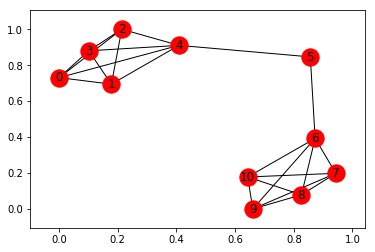

In [153]:
nx.draw_networkx(G)

In [154]:
centralityG = nx.centrality.betweenness_centrality(G)

In [155]:
centralityG

{0: 0.0,
 1: 0.0,
 2: 0.0,
 3: 0.0,
 4: 0.5333333333333333,
 5: 0.5555555555555556,
 6: 0.5333333333333333,
 7: 0.0,
 8: 0.0,
 9: 0.0,
 10: 0.0}

In [156]:
list(nx.find_cliques(G))

[[4, 0, 1, 2, 3], [4, 5], [6, 8, 9, 10, 7], [6, 5]]

In [157]:
nx.triangles(G)

{0: 6, 1: 6, 2: 6, 3: 6, 4: 6, 5: 0, 6: 6, 7: 6, 8: 6, 9: 6, 10: 6}

In [158]:
flow_value, flow_dict = nx.maximum_flow(network, 72, 79, capacity='inv_weight')

In [159]:
flow_value

30.511215329257062

In [171]:
import networkx as nx
T = nx.DiGraph()
T.add_edge('x','a', capacity=3.0)
T.add_edge('x','b', capacity=1.0)
T.add_edge('a','c', capacity=3.0)
T.add_edge('b','c', capacity=5.0)
T.add_edge('b','d', capacity=4.0)
T.add_edge('d','e', capacity=2.0)
T.add_edge('c','y', capacity=2.0)
T.add_edge('e','y', capacity=3.0)

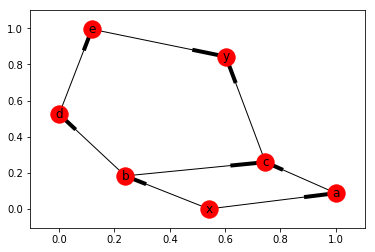

In [172]:
nx.draw_networkx(T,with_labels=True)

In [209]:
flow_value, flow_dict = nx.maximum_flow(T, 'x', 'c', capacity='capacity')

In [210]:
flow_value

4.0

In [208]:
flow_dict

{'a': {'c': 2.0},
 'b': {'c': 0, 'd': 1.0},
 'c': {'y': 2.0},
 'd': {'e': 1.0},
 'e': {'y': 1.0},
 'x': {'a': 2.0, 'b': 1.0},
 'y': {}}

In [154]:
cent = nx.centrality.betweenness_centrality(network, weight='inv_weight')

In [159]:
centralities = pd.DataFrame({'station_id': list(cent.keys()), 'cents': list(cent.values())}).set_index('station_id')

In [217]:
stations = (data[['start station id', 'start station latitude', 'start station longitude']]
            .drop_duplicates('start station id')
            .rename(columns={'start station latitude':'latitude', 'start station longitude':'longitude'})
            .set_index('start station id'))

In [412]:
stations.head()

,start station id,latitude,longitude,start station name
0,164,40.753231,-73.970325,E 47 St & 2 Ave
1,388,40.749718,-74.002950,W 26 St & 10 Ave
2,293,40.730287,-73.990765,Lafayette St & E 8 St
3,531,40.718939,-73.992663,Forsyth St & Broome St
4,382,40.734927,-73.992005,University Pl & E 14 St


In [162]:
start_rides = data.groupby('start station id').count().rename(columns={'tripduration':'start_count'})['start_count']
end_rides   = data.groupby('end station id').count().rename(columns={'tripduration':'end_count'})['end_count']

In [163]:
data.groupby('start station id').count().rename(columns={'bikeid':'start_count'})['start_count'].head()

start station id
72     18663
79     18765
82      7272
83      9722
116    31377
Name: start_count, dtype: int64

In [164]:
geometry = [Point(xy) for xy in zip(stations.longitude, stations.latitude)]

In [165]:
gp.GeoDataFrame(stations.join(centralities.join(start_rides).join(end_rides))).to_csv('bike_share_full_directed.csv')

In [166]:
ranks=nx.pagerank(network, alpha=0.9, weight='weight')
ranks_inv=nx.pagerank(network, alpha=0.9, weight='inv_weight')

In [167]:
result = centralities.join(start_rides).join(end_rides).join(pd.Series(ranks, name='ranks')).join(pd.Series(ranks_inv, name='inv_ranks'))

In [72]:
import seaborn as sns
from scipy.stats import kendalltau
import numpy as np

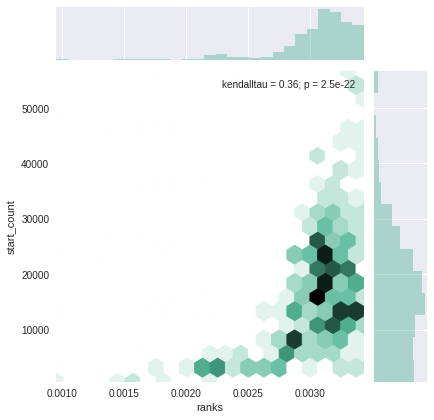

In [81]:
sns.jointplot(result['ranks'], result['start_count'], kind="hex", stat_func=kendalltau, color="#4CB391")

In [ ]:
cliques = [ cluque for cluque in nx.clique.find_cliques(network)]

In [105]:
cliques[0]

NameError: name 'cliques' is not defined

In [82]:
result.index = pd.Int64Index(result.index)

In [84]:
stations.join(result).to_csv('bikes_with_page_rank.csv')

In [52]:
stations.ix[382]

latitude     40.734927
longitude   -73.992005
Name: 382, dtype: float64

In [53]:
len((data[['start station id', 'start station latitude', 'start station longitude']]
            .drop_duplicates()))

660

In [83]:
result

,cents,start_count,end_count,ranks,inv_ranks
station_id,,,,,
72,0.000825,18663,19962,0.003111,0.002454
79,0.000139,18765,18847,0.003131,0.002008
82,0.000000,7272,7222,0.003220,0.003917
83,0.000204,9722,10443,0.003402,0.001981
116,0.004346,31377,31083,0.003190,0.002183
119,0.000000,1265,1228,0.001538,0.004142
120,0.000000,3243,3288,0.002713,0.005880
127,0.003040,29862,30423,0.003252,0.002070
128,0.008915,31618,32284,0.003337,0.001997


In [87]:
census_result  = nx.triadic_census(network)

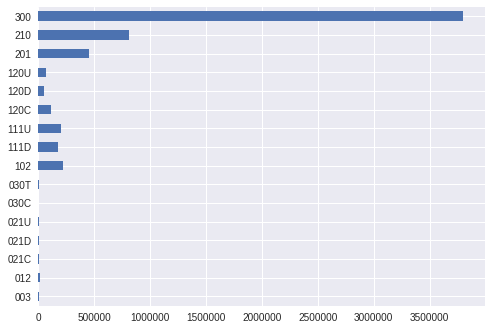

In [92]:
pd.Series(census_result).plot(kind='barh')

In [101]:
start_id = stations['latitude'].sort_values().index[-1]
end_id = stations['latitude'].sort_values().index[0]

In [108]:
end_id

396

In [105]:
flow_val, flow_dict= nx.maximum_flow(network, start_id, end_id,capacity='inv_weight')

In [106]:
flow_dict

{72.0: {72.0: 0,
  79.0: 0.0072992700729927005,
  82.0: 0.16666666666666666,
  83.0: 0.052631578947368418,
  116.0: 0.013333333333333334,
  119.0: 1.0,
  120.0: 0.33333333333333331,
  127.0: 0.007462686567164179,
  128.0: 0.013157894736842105,
  137.0: 0.02,
  146.0: 0.032258064516129031,
  147.0: 0.012500000000000001,
  150.0: 0.083333333333333329,
  151.0: 0.030303030303030304,
  152.0: 0.017543859649122806,
  153.0: 0.011494252873563218,
  157.0: 0.14850277854561478,
  160.0: 0,
  161.0: 0,
  164.0: 0,
  167.0: 0,
  168.0: 0,
  173.0: 0,
  174.0: 0,
  195.0: 0,
  212.0: 0,
  216.0: 0,
  218.0: 0,
  223.0: 0,
  224.0: 0,
  225.0: 0,
  228.0: 0,
  229.0: 0,
  232.0: 0,
  233.0: 0,
  236.0: 0,
  237.0: 0,
  238.0: 0,
  239.0: 0,
  242.0: 0,
  243.0: 0,
  244.0: 0,
  245.0: 0,
  247.0: 0,
  248.0: 0,
  249.0: 0,
  250.0: 0,
  251.0: 0,
  252.0: 0,
  253.0: 0,
  254.0: 0,
  257.0: 0,
  259.0: 0,
  260.0: 0,
  261.0: 0,
  263.0: 0,
  264.0: 0,
  265.0: 0,
  267.0: 0,
  268.0: 0,
  271.0: 

In [109]:
cliques = nx.find_cliques(network)

NetworkXNotImplemented: not implemented for directed type

In [111]:
nx.find_cycle(network)

[(72.0, 72.0)]

In [117]:
help(nx.find_cycle)

Help on function find_cycle in module networkx.algorithms.cycles:

find_cycle(G, source=None, orientation='original')
    Returns the edges of a cycle found via a directed, depth-first traversal.
    
    Parameters
    ----------
    G : graph
        A directed/undirected graph/multigraph.
    
    source : node, list of nodes
        The node from which the traversal begins. If ``None``, then a source
        is chosen arbitrarily and repeatedly until all edges from each node in
        the graph are searched.
    
    orientation : 'original' | 'reverse' | 'ignore'
        For directed graphs and directed multigraphs, edge traversals need not
        respect the original orientation of the edges. When set to 'reverse',
        then every edge will be traversed in the reverse direction. When set to
        'ignore', then each directed edge is treated as a single undirected
        edge that can be traversed in either direction. For undirected graphs
        and undirected multigraph

In [119]:
def path_exists(G,node1,node2):
    """
    This function checks whether a path exists between two nodes (node1, node2) in graph G.
    """
    visited_nodes = set()
    
    # Initialize the queue of cells to visit with the first node: queue
    queue = [node1]
    
    # Iterate over the nodes in the queue
    for node in queue:
    
        # Get neighbors of the node
        neighbors = G.neighbors(node) 
        
        # Check to see if the destination node is in the set of neighbors
        if node2 in neighbors:
            print('Path exists between nodes {0} and {1}'.format(node1, node2))
            return True
        else:
            return False
            break

In [120]:
path_exists(G,1,7)

False

In [1]:
data

NameError: name 'data' is not defined